# Correlation Analysis
---

In [1]:
import itertools
from itertools import combinations_with_replacement

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

%load_ext nb_black

<IPython.core.display.Javascript object>

## Preprocessing
***

In [2]:
def cast_to_datetime(df, col):
    return df[col].astype("datetime64[ns]")


def cast_to_datetime_all(df_polls, candidates, newspapers, candidates_name):
    df_polls["Date_start"] = cast_to_datetime(df_polls, "Date_start")
    df_polls["Date_end"] = cast_to_datetime(df_polls, "Date_end")
    
    for df_candidate in candidates:
        df_candidate["date"] = cast_to_datetime(df_candidate, "date")
    
    for df_newspaper in newspapers:
        df_newspaper["date"] = cast_to_datetime(df_newspaper, "date")
    
    return {"polls": df_polls, "candidates":  candidates, "newspapers": newspapers, "names": candidates_name}

<IPython.core.display.Javascript object>

In [3]:
# Change to false if you don't want to load a certain year
flag_2012 = True
flag_2016 = True
flag_2020 = True

## Load data
PATH_2012 = "DATA\\2012\\"
PATH_2016 = "DATA\\2016\\"
PATH_2020 = "DATA\\2020\\"
PATH_PREPROCESSED = "Data\\preprocessed\\"

data = []

if flag_2012:  
    df_polls_2012 = pd.read_csv(PATH_PREPROCESSED + "polls_2012.csv")
    
    df_sentiment_obama_2012 = pd.read_csv(PATH_PREPROCESSED + "sentiment_obama_2012.csv")
    df_sentiment_romney_2012 = pd.read_csv(PATH_PREPROCESSED + "sentiment_romney_2012.csv")
    
    candidates_2012 = [df_sentiment_obama_2012, df_sentiment_romney_2012]
    
    df_bbc_2012 = pd.read_csv(PATH_2012 + "bbc_2012.zip")
    df_foxnews_2012 = pd.read_csv(PATH_2012 + "foxnews_2012.zip")
    df_nytimes_2012 = pd.read_csv(PATH_2012 + "ny_times_2012.zip")
    
    newspaper_2012 = [df_bbc_2012, df_foxnews_2012, df_nytimes_2012]
    
    data.append(("2012", cast_to_datetime_all(df_polls_2012, candidates_2012, newspaper_2012, ["Obama", "Romney"])))
    
if flag_2016:
    df_polls_2016 = pd.read_csv(PATH_PREPROCESSED + "polls_2016.csv")
    
    df_sentiment_clinton_2016 = pd.read_csv(PATH_PREPROCESSED + "sentiment_clinton_2016.csv")
    df_sentiment_trump_2016 = pd.read_csv(PATH_PREPROCESSED + "sentiment_trump_2016.csv")
    
    candidates_2016 = [df_sentiment_clinton_2016, df_sentiment_trump_2016]
    
    df_bbc_2016 = pd.read_csv(PATH_2016 + "bbc_2016.zip")
    df_foxnews_2016 = pd.read_csv(PATH_2016 + "foxnews_2016.zip")
    df_nytimes_2016 = pd.read_csv(PATH_2016 + "ny_times_2016.zip")
    
    newspaper_2016 = [df_bbc_2016, df_foxnews_2016, df_nytimes_2016]
    
    data.append(("2016", cast_to_datetime_all(df_polls_2016, candidates_2016, newspaper_2016, ["Clinton", "Trump"])))
    
if flag_2020:
    df_polls_2020 = pd.read_csv(PATH_PREPROCESSED + "polls_2020.csv")

    df_sentiment_biden_2020 = pd.read_csv(PATH_PREPROCESSED + "sentiment_biden_2020.csv")
    df_sentiment_trump_2020 = pd.read_csv(PATH_PREPROCESSED + "sentiment_trump_2020.csv")

    candidates_2020 = [df_sentiment_biden_2020, df_sentiment_trump_2020]
    
    df_bbc_2020 = pd.read_csv(PATH_2020 + "bbc_2020.zip")
    df_foxnews_2020 = pd.read_csv(PATH_2020 + "foxnews_2020.zip")
    df_nytimes_2020 = pd.read_csv(PATH_2020 + "ny_times_2020.zip")
    
    newspaper_2020 = [df_bbc_2020, df_foxnews_2020, df_nytimes_2020]
    
    data.append(("2020", cast_to_datetime_all(df_polls_2020, candidates_2020, newspaper_2020, ["Biden", "Trump"])))

<IPython.core.display.Javascript object>

### Aggregation

- #### By week

In [4]:
def check_columns(newspaper, df_newspaper, df_candidate):
    check = True
    
    if "date" not in df_newspaper.columns:
        print("Error: missing 'date' column in df_newspaper")
        check = False
        
    if "date" not in df_candidate.columns:
        print("Error: missing 'date' column in df_candidate")
        check = False
        
    if "type" not in df_candidate.columns:
        print("Error: missing 'type' column in df_candidate")
        check = False
    elif newspaper not in df_candidate.type.unique():
        print(f"Error: newspaper '{newspaper}' is not in the list of newspapers")
        check = False
    
    return check;


def aggregate_by_week(df, col, operation):
    df = df.sort_values("date")
    df.loc[:, "week"] = df.loc[:, "date"].dt.strftime("%U")
    df_weekly_occurrences = df.groupby("week", as_index=False).agg({col : operation}).rename(columns={col : f"{col}_{operation}"})
    df_weekly_occurrences["week"] = df_weekly_occurrences["week"].astype("int64")
    
    return df_weekly_occurrences


def merge_occurrences(df_newspaper_occurrences, df_candidate_occurrences):
    df_counts = df_newspaper_occurrences.set_index("week").join(
        df_candidate_occurrences.set_index("week"),
        on="week",
        how="left",
        lsuffix="_newspaper",
        rsuffix="_candidate",
    )

    df_counts = df_counts[["date_count_newspaper", "date_count_candidate"]]
    df_counts["weekly_occurrences_rescaled"] = (df_counts["date_count_candidate"] / df_counts["date_count_newspaper"])
    
    return df_counts
    

def compute_weekly_rescaled_occurences_intention(newspaper, df_newspaper, df_candidate, df_polls, intention_idx = 0):
    candidate = df_polls.columns[4 + intention_idx]
    
    print(f"Candidate: {candidate}, newspaper: {newspaper}")
    
    df_polls = df_polls.rename(columns={"Date_end" : "date", df_polls.columns[4 + intention_idx]: "intention"})
    
    if not check_columns(newspaper, df_newspaper, df_candidate):
        return
    
    df_newspaper_weekly_occurrences = aggregate_by_week(df_newspaper, "date", "count")
    df_candidate_weekly_occurrences = aggregate_by_week(df_candidate[df_candidate.type == newspaper], "date", "count")
    df_intention_weekly_averaged = aggregate_by_week(df_polls, "intention", "mean")
     
    df_counts = merge_occurrences(df_newspaper_weekly_occurrences, df_candidate_weekly_occurrences)
    
    df_occurrences_intention = df_counts.join(
        df_intention_weekly_averaged.set_index("week"),
        on="week",
        how="inner",
    )

    return df_occurrences_intention[["weekly_occurrences_rescaled", "intention_mean"]].rename_axis('week').reset_index()

<IPython.core.display.Javascript object>

In [5]:
dict_wroi = {}

for year in data:
    for intention_idx in [0, 1]:
        for newspaper_idx in [0, 1, 2]:
            df_polls = year[1]["polls"]

            df_candidate = year[1]["candidates"][intention_idx]
            condidate_name = year[1]["names"][intention_idx]

            df_newspaper = year[1]["newspapers"][newspaper_idx]
            newspaper_name = ["BBC", "Fox News", "NY Times"][newspaper_idx]

            dict_wroi[
                (year[0], condidate_name, newspaper_name)
            ] = compute_weekly_rescaled_occurences_intention(
                newspaper_name,
                df_newspaper[["date"]],
                df_candidate[["type", "date"]],
                df_polls,
                intention_idx,
            )

Candidate: Obama (D), newspaper: BBC
Candidate: Obama (D), newspaper: Fox News
Candidate: Obama (D), newspaper: NY Times
Candidate: Romney (R), newspaper: BBC
Candidate: Romney (R), newspaper: Fox News
Candidate: Romney (R), newspaper: NY Times
Candidate: Clinton (D), newspaper: BBC
Candidate: Clinton (D), newspaper: Fox News
Candidate: Clinton (D), newspaper: NY Times
Candidate: Trump (R), newspaper: BBC
Candidate: Trump (R), newspaper: Fox News
Candidate: Trump (R), newspaper: NY Times
Candidate: Biden (D), newspaper: BBC
Candidate: Biden (D), newspaper: Fox News
Candidate: Biden (D), newspaper: NY Times
Candidate: Trump (R), newspaper: BBC
Candidate: Trump (R), newspaper: Fox News
Candidate: Trump (R), newspaper: NY Times


<IPython.core.display.Javascript object>

In [6]:
df_all = pd.DataFrame()
week_count = 0

for year in data:
    for intention_idx in [0, 1]:
        newspaper_count = 0
        
        for newspaper_idx in [0, 1, 2]:
            df_polls = year[1]["polls"]

            df_candidate = year[1]["candidates"][intention_idx]
            condidate_name = year[1]["names"][intention_idx]

            df_newspaper = year[1]["newspapers"][newspaper_idx]
            newspaper_name = ["BBC", "Fox News", "NY Times"][newspaper_idx]
            
            df_temp = compute_weekly_rescaled_occurences_intention(
                newspaper_name,
                df_newspaper[["date"]],
                df_candidate[["type", "date"]],
                df_polls,
                intention_idx,
            )
            
            if week_count == 0:
                df_all["week"] = df_temp["week"]
                week_count += 1
            
            if newspaper_count == 0:
                df_all[f"intention_mean_{year[0]}_{condidate_name}"] = df_temp["intention_mean"]
            
            df_all[f"wor_{year[0]}_{condidate_name}_{newspaper_name}"] = df_temp["weekly_occurrences_rescaled"]

# Save dataset df_all
# df_all.to_csv(f"Data\preprocessed\weekly_rescaled_occurences_intention.csv", index=False) 

Candidate: Obama (D), newspaper: BBC
Candidate: Obama (D), newspaper: Fox News
Candidate: Obama (D), newspaper: NY Times
Candidate: Romney (R), newspaper: BBC
Candidate: Romney (R), newspaper: Fox News
Candidate: Romney (R), newspaper: NY Times
Candidate: Clinton (D), newspaper: BBC
Candidate: Clinton (D), newspaper: Fox News
Candidate: Clinton (D), newspaper: NY Times
Candidate: Trump (R), newspaper: BBC
Candidate: Trump (R), newspaper: Fox News
Candidate: Trump (R), newspaper: NY Times
Candidate: Biden (D), newspaper: BBC
Candidate: Biden (D), newspaper: Fox News
Candidate: Biden (D), newspaper: NY Times
Candidate: Trump (R), newspaper: BBC
Candidate: Trump (R), newspaper: Fox News
Candidate: Trump (R), newspaper: NY Times


<IPython.core.display.Javascript object>

In [7]:
# candidate = 0
# sentiment_dataset = candidates_2012[candidate]
# candidates_dataset = df_candidates_2012


# def func_apply(x):
#     """
#     Take the mean of numOccurrences, quotation_polarity, quotation_subjectivity
#     during a the period of time of the survey x. Also output the vote intention.
#     """
#     df_temp = sentiment_dataset.loc[
#         (candidates_dataset.date >= x.Date_start)
#         & (candidates_dataset.date < x.Date_end)
#     ]

#     return df_temp.describe().transpose()["mean"].append(pd.Series(x[candidate]))


# df = df_polls_2012.apply(func_apply, axis=1)
# df.dropna(inplace=True)
# df.rename(columns={0: "intention"}, inplace=True)
# df.describe().transpose()

# mmscaler = MinMaxScaler()
# stdscaler = StandardScaler()
# cols = df.columns

# for col in cols:
#     df[f"{col}_scaled"] = mmscaler.fit_transform(df[col].to_numpy().reshape(-1, 1))

# for col in cols:
#     df[f"{col}_standardized"] = stdscaler.fit_transform(
#         df[col].to_numpy().reshape(-1, 1)
#     )

# df.describe().transpose()

<IPython.core.display.Javascript object>

## Regression Analysis
---

- #### By week

In [8]:
def baseline_model(df):
    df = df.dropna()
    l = []
    for cols in combinations_with_replacement(df.columns, 2):
        corr, _ = pearsonr(df[cols[0]], df[cols[1]])
        l.append((corr, cols[0], cols[1]))
    
    for elem in l:
        print(elem)

def linear_regresion_model(df, formula):
    mod = smf.ols(
        formula=formula,
        data=df.dropna(),
    )
    res = mod.fit()
    print(res.summary())

<IPython.core.display.Javascript object>

In [9]:
# PATH_PREPROCESSED = "Data\\preprocessed\\"
# df_all = pd.read_csv(PATH_PREPROCESSED + "weekly_rescaled_occurences_intention.csv")
# df_all.columns

<IPython.core.display.Javascript object>

I will use the dictionary for simplicity:

('2012', 'Obama', 'BBC')


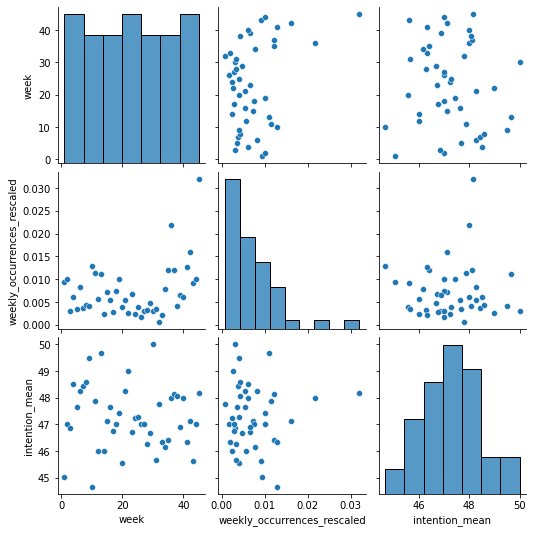

(1.0, 'week', 'week')
(0.31428030378728405, 'week', 'weekly_occurrences_rescaled')
(-0.07759892427300003, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.017108856607906966, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                   0.01259
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.911
Time:                        00:59:41   Log-Likelihood:                -70.888
No. Observations:                  45   AIC:                             145.8
Df Residuals:                      43   BIC:                             149.4
Df Model:                           1                 

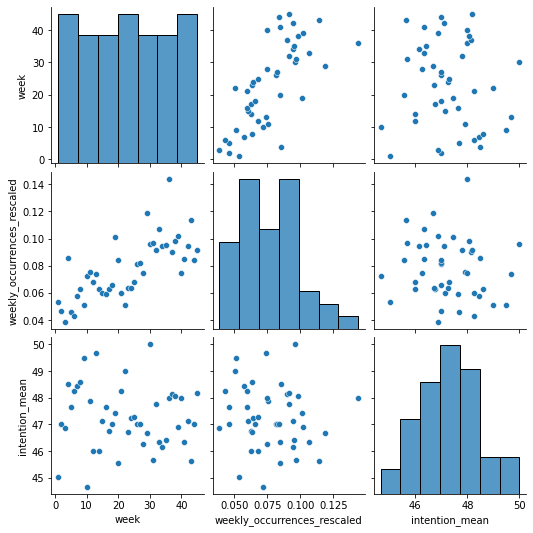

(1.0, 'week', 'week')
(0.7214528983906048, 'week', 'weekly_occurrences_rescaled')
(-0.07759892427300003, 'week', 'intention_mean')
(0.9999999999999999, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(-0.11584714745970207, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5849
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.449
Time:                        00:59:43   Log-Likelihood:                -70.590
No. Observations:                  45   AIC:                             145.2
Df Residuals:                      43   BIC:                             148.8
Df Model:                           1   

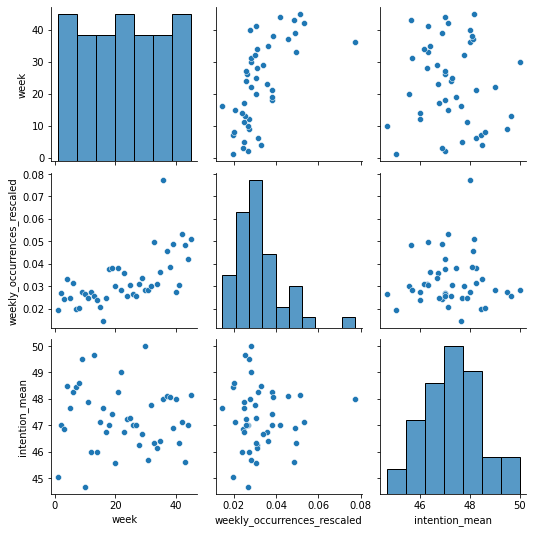

(1.0, 'week', 'week')
(0.6314811835223435, 'week', 'weekly_occurrences_rescaled')
(-0.07759892427300003, 'week', 'intention_mean')
(0.9999999999999999, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.00559087305190651, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                  0.001344
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.971
Time:                        00:59:45   Log-Likelihood:                -70.894
No. Observations:                  45   AIC:                             145.8
Df Residuals:                      43   BIC:                             149.4
Df Model:                           1    

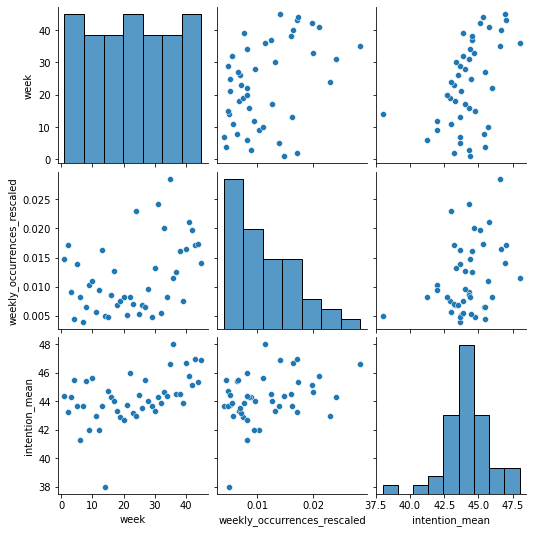

(1.0, 'week', 'week')
(0.4023414959505032, 'week', 'weekly_occurrences_rescaled')
(0.47717254457375957, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.3412603941494008, 'weekly_occurrences_rescaled', 'intention_mean')
(0.9999999999999998, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     5.668
Date:                Sat, 11 Dec 2021   Prob (F-statistic):             0.0218
Time:                        00:59:47   Log-Likelihood:                -84.309
No. Observations:                  45   AIC:                             172.6
Df Residuals:                      43   BIC:                             176.2
Df Model:                           1      

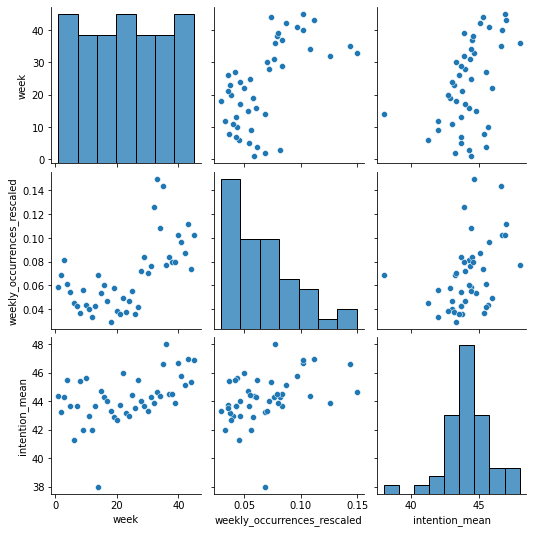

(1.0, 'week', 'week')
(0.6070452687766376, 'week', 'weekly_occurrences_rescaled')
(0.47717254457375957, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.39929654425794736, 'weekly_occurrences_rescaled', 'intention_mean')
(0.9999999999999998, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     8.156
Date:                Sat, 11 Dec 2021   Prob (F-statistic):            0.00658
Time:                        00:59:48   Log-Likelihood:                -83.187
No. Observations:                  45   AIC:                             170.4
Df Residuals:                      43   BIC:                             174.0
Df Model:                           1     

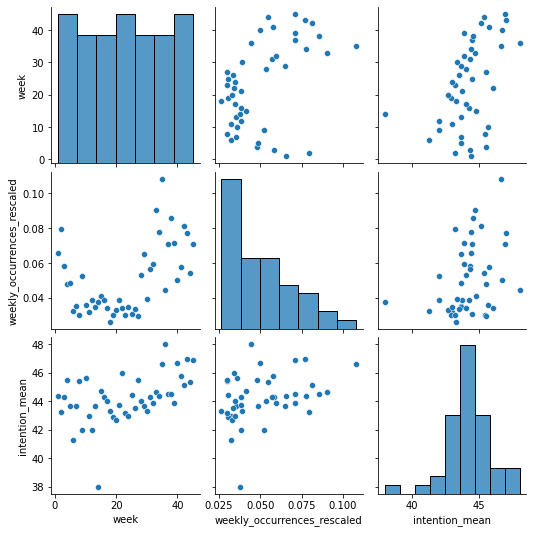

(1.0, 'week', 'week')
(0.4645704687913571, 'week', 'weekly_occurrences_rescaled')
(0.47717254457375957, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.3423846880177727, 'weekly_occurrences_rescaled', 'intention_mean')
(0.9999999999999998, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     5.710
Date:                Sat, 11 Dec 2021   Prob (F-statistic):             0.0213
Time:                        00:59:50   Log-Likelihood:                -84.289
No. Observations:                  45   AIC:                             172.6
Df Residuals:                      43   BIC:                             176.2
Df Model:                           1      

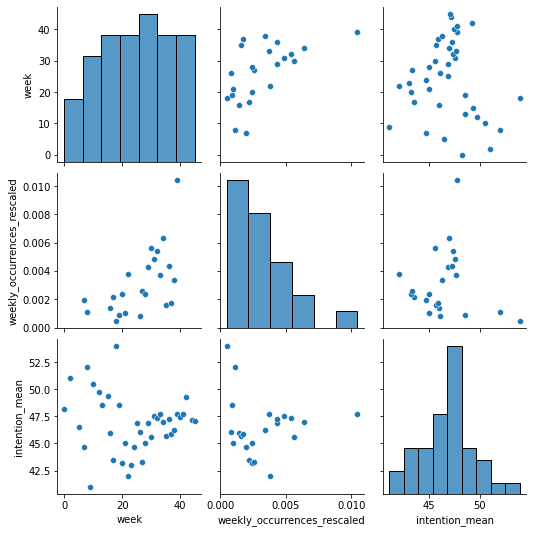

(0.9999999999999998, 'week', 'week')
(0.590052122079972, 'week', 'weekly_occurrences_rescaled')
(-0.07524182353104224, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(-0.05125152606642061, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                   0.05531
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.816
Time:                        00:59:52   Log-Likelihood:                -54.697
No. Observations:                  23   AIC:                             113.4
Df Residuals:                      21   BIC:                             115.7
Df Model:                           1    

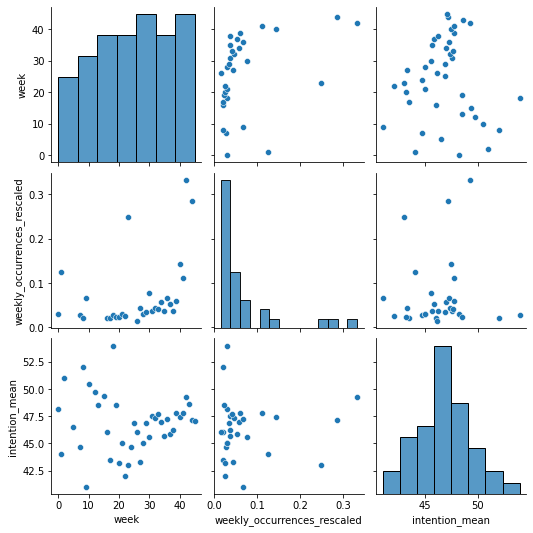

(1.0, 'week', 'week')
(0.3754976112763004, 'week', 'weekly_occurrences_rescaled')
(0.1701476137098204, 'week', 'intention_mean')
(0.9999999999999999, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.03831628407184808, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                   0.04264
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.838
Time:                        00:59:53   Log-Likelihood:                -74.208
No. Observations:                  31   AIC:                             152.4
Df Residuals:                      29   BIC:                             155.3
Df Model:                           1      

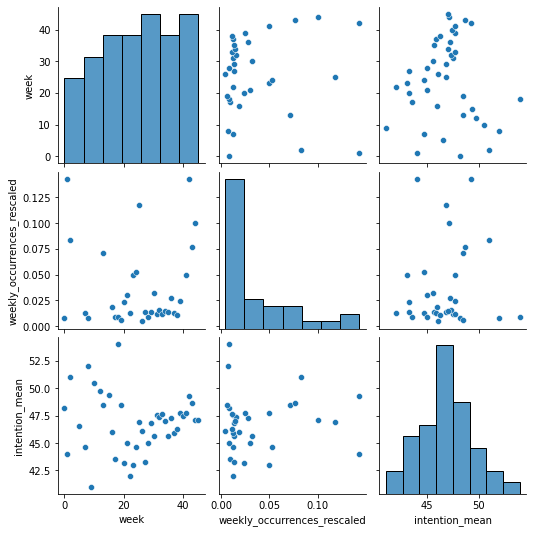

(1.0, 'week', 'week')
(0.021456168686363443, 'week', 'weekly_occurrences_rescaled')
(-0.027036355874310764, 'week', 'intention_mean')
(0.9999999999999999, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.08378649292430586, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2262
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.638
Time:                        00:59:55   Log-Likelihood:                -79.818
No. Observations:                  34   AIC:                             163.6
Df Residuals:                      32   BIC:                             166.7
Df Model:                           1 

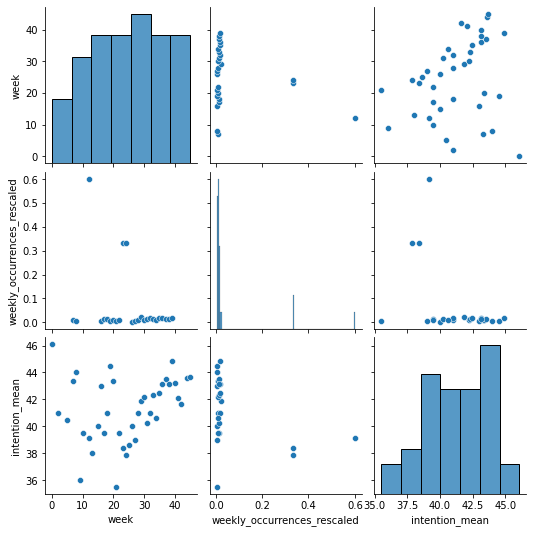

(0.9999999999999997, 'week', 'week')
(-0.2691468347134295, 'week', 'weekly_occurrences_rescaled')
(0.15451768874317975, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(-0.4063134410417573, 'weekly_occurrences_rescaled', 'intention_mean')
(0.9999999999999999, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4.746
Date:                Sat, 11 Dec 2021   Prob (F-statistic):             0.0394
Time:                        00:59:57   Log-Likelihood:                -55.559
No. Observations:                  26   AIC:                             115.1
Df Residuals:                      24   BIC:                             117.6
Df Model:                 

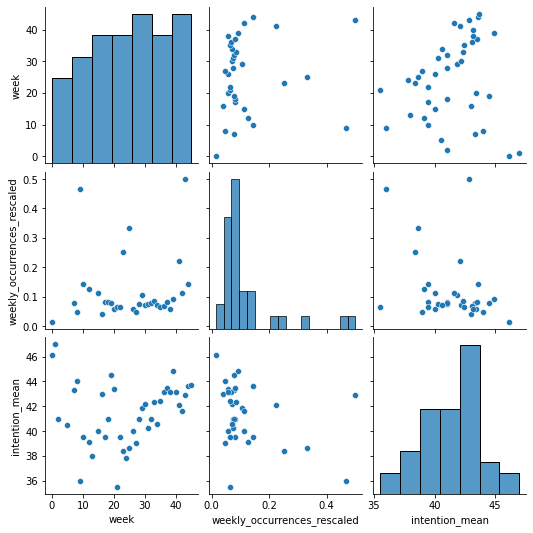

(0.9999999999999998, 'week', 'week')
(0.1129218263099723, 'week', 'weekly_occurrences_rescaled')
(0.18458623238086821, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(-0.33627683194218233, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.080
Date:                Sat, 11 Dec 2021   Prob (F-statistic):             0.0518
Time:                        00:59:59   Log-Likelihood:                -75.490
No. Observations:                  34   AIC:                             155.0
Df Residuals:                      32   BIC:                             158.0
Df Model:                           1    

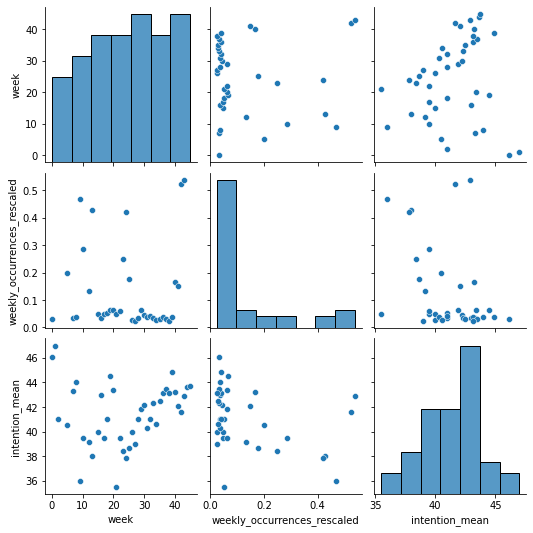

(1.0, 'week', 'week')
(0.02360699976205613, 'week', 'weekly_occurrences_rescaled')
(0.20907716143968624, 'week', 'intention_mean')
(0.9999999999999997, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(-0.3657617604865448, 'weekly_occurrences_rescaled', 'intention_mean')
(0.9999999999999999, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     5.406
Date:                Sat, 11 Dec 2021   Prob (F-statistic):             0.0260
Time:                        01:00:00   Log-Likelihood:                -82.114
No. Observations:                  37   AIC:                             168.2
Df Residuals:                      35   BIC:                             171.5
Df Model:                 

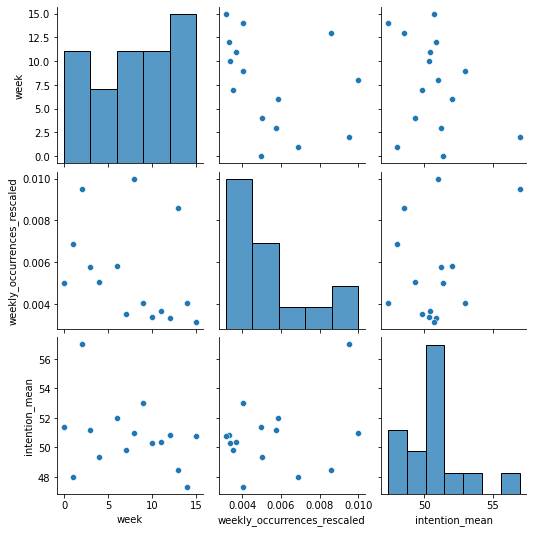

(0.9999999999999999, 'week', 'week')
(-0.3636036199135465, 'week', 'weekly_occurrences_rescaled')
(-0.3355111373863798, 'week', 'intention_mean')
(0.9999999999999998, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.2852709098276035, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.152
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.303
Time:                        01:00:02   Log-Likelihood:                -32.606
No. Observations:                  15   AIC:                             69.21
Df Residuals:                      13   BIC:                             70.63
Df Model:                  

c:\users\dream\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


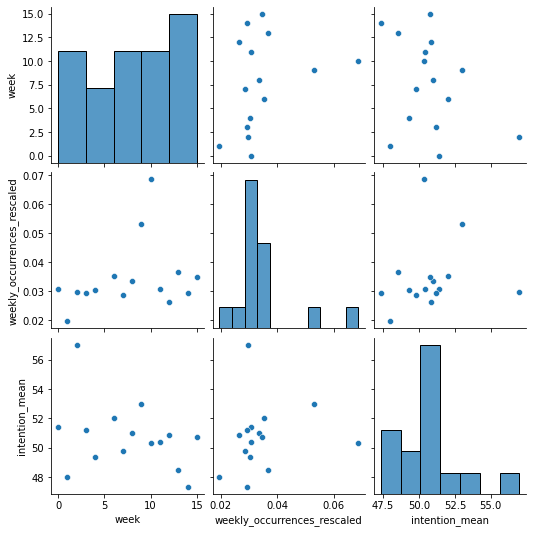

(0.9999999999999999, 'week', 'week')
(0.2879766521363503, 'week', 'weekly_occurrences_rescaled')
(-0.3355111373863798, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.15406802260743285, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.3161
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.584
Time:                        01:00:04   Log-Likelihood:                -33.062
No. Observations:                  15   AIC:                             70.12
Df Residuals:                      13   BIC:                             71.54
Df Model:                           1     

c:\users\dream\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


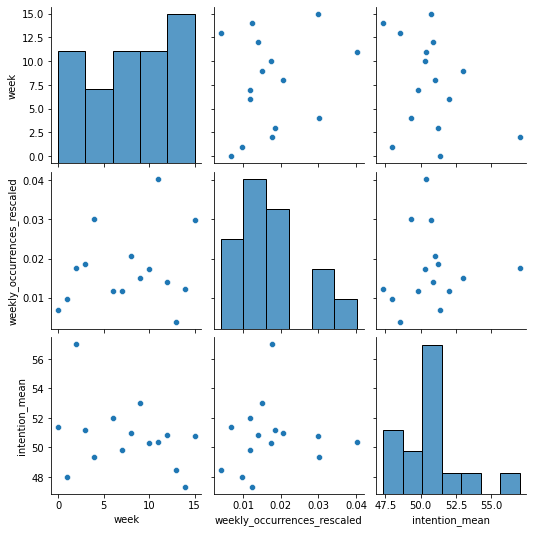

(0.9999999999999999, 'week', 'week')
(0.21104075239847786, 'week', 'weekly_occurrences_rescaled')
(-0.3355111373863798, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.09661743999110282, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.067
Method:                 Least Squares   F-statistic:                    0.1225
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.732
Time:                        01:00:05   Log-Likelihood:                -33.172
No. Observations:                  15   AIC:                             70.34
Df Residuals:                      13   BIC:                             71.76
Df Model:                           1    

c:\users\dream\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


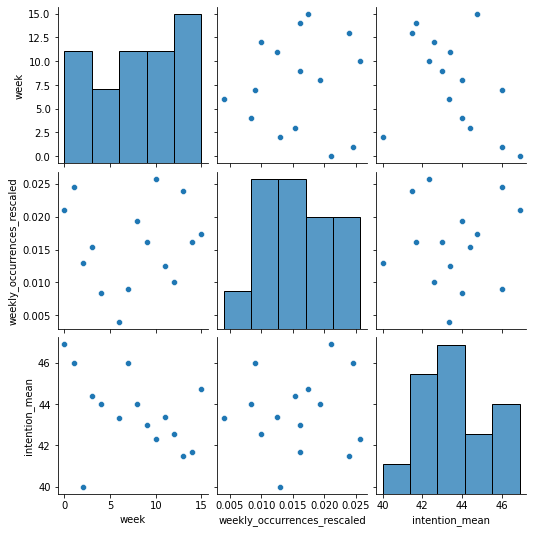

(0.9999999999999999, 'week', 'week')
(0.0409030952795895, 'week', 'weekly_occurrences_rescaled')
(-0.3994300426984444, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.06617964617310951, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                   0.05719
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.815
Time:                        01:00:07   Log-Likelihood:                -30.119
No. Observations:                  15   AIC:                             64.24
Df Residuals:                      13   BIC:                             65.65
Df Model:                           1     

c:\users\dream\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


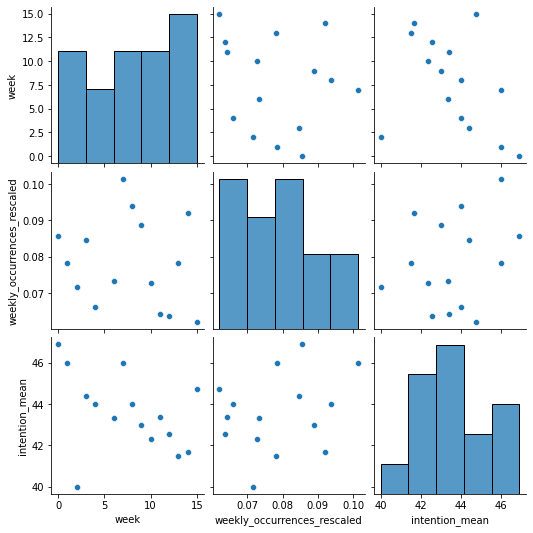

(0.9999999999999999, 'week', 'week')
(-0.174908113836459, 'week', 'weekly_occurrences_rescaled')
(-0.3994300426984444, 'week', 'intention_mean')
(1.0, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(0.2638249046926075, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9725
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.342
Time:                        01:00:09   Log-Likelihood:                -29.611
No. Observations:                  15   AIC:                             63.22
Df Residuals:                      13   BIC:                             64.64
Df Model:                           1      

c:\users\dream\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


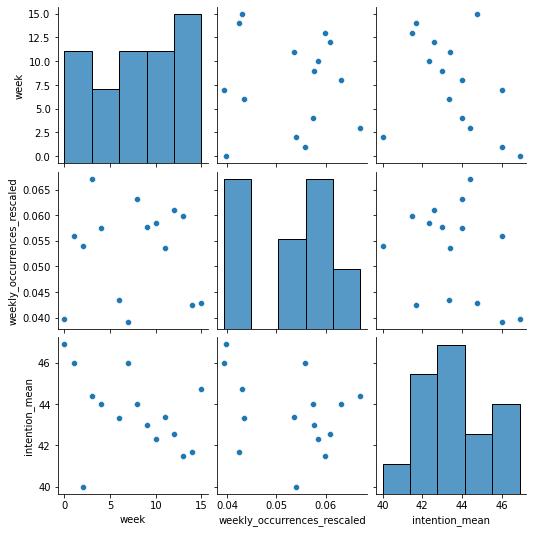

(0.9999999999999999, 'week', 'week')
(-0.03915206797296521, 'week', 'weekly_occurrences_rescaled')
(-0.3994300426984444, 'week', 'intention_mean')
(0.9999999999999999, 'weekly_occurrences_rescaled', 'weekly_occurrences_rescaled')
(-0.32342426992844403, 'weekly_occurrences_rescaled', 'intention_mean')
(1.0, 'intention_mean', 'intention_mean')
                            OLS Regression Results                            
Dep. Variable:         intention_mean   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.519
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.240
Time:                        01:00:10   Log-Likelihood:                -29.323
No. Observations:                  15   AIC:                             62.65
Df Residuals:                      13   BIC:                             64.06
Df Model:               

c:\users\dream\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<IPython.core.display.Javascript object>

In [10]:
for key in dict_wroi:
    df = dict_wroi[key]
    print(key)
    sns.pairplot(df)
    plt.show()
    baseline_model(df)
    linear_regresion_model(df, "intention_mean ~ weekly_occurrences_rescaled")
    print("\n\n")

- #### By survey period

In [11]:
# mod = smf.ols(
#     formula="intention ~ quotation_polarity + numOccurrences + quotation_subjectivity",
#     data=df,
# )
# res = mod.fit()
# print(res.summary())

<IPython.core.display.Javascript object>

In [12]:
# mod = smf.ols(
#     formula="intention_scaled ~ quotation_polarity_scaled + numOccurrences_scaled + quotation_subjectivity_scaled",
#     data=df,
# )
# res = mod.fit()
# print(res.summary())

<IPython.core.display.Javascript object>

Feature scaling does not seem to help.

In [13]:
# mod = smf.ols(
#     formula="intention_standardized ~ quotation_polarity_standardized + numOccurrences_standardized + quotation_subjectivity_standardized",
#     data=df,
# )
# res = mod.fit()
# print(res.summary())

<IPython.core.display.Javascript object>

In [14]:
# corr, _ = pearsonr(df["intention"], df["numOccurrences"])
# corr

<IPython.core.display.Javascript object>